# Reconocimiento y Clasificacion de rostros con Redes Neuronales Convolucionales en Keras

La idea del proyecto es implementar distintas arquitecturas de redes neuronales para el procesamiento e identificacion de rostros, a partir de los modelos preentrenados disponible en Keras y de los distintos modelos en los papers mencionados.



Para personalizar el problema a partir del script faceDetection.py, hay que crear una carpeta que contenga el dataset, para ir caragandola con cada ejecucion de detectarProcesar_cara.py con imagenes croppeadas y alineadas, listas para entrenar los modelos.

Para el correcto funcionamiento es necesaria la libreria DLIB con el modelo preentrenado shape_predictor_68_face_landamarks.dat, disponible en https://github.com/davisking/dlib-models

Hay que ingresar como parametro la etiqueta de la persona a identificar. 
La direccion del dataset dentro del script 
Ejecutarlo con el comando: python detectarProcesar_cara.py ETIQUETA

Con 's' sacas fotos, con 'q' salis.

Aclaracion: esta forma manual de cargar el dataset no es del todo efectiva... Cargando foto a foto el dataset se hace tedioso, considerando que un dataset chico tiene miles de imagenes.
Lo ideal seria hacer un script que cargue automaticamente los datasets cada vez que identifica (durante un minimo intervalo de tiempo) a una persona ya registrada en el dataset.

In [23]:
from keras.layers import Input,Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Lambda
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras import regularizers
from keras.callbacks import EarlyStopping


import PIL
import cv2
import numpy as np
import matplotlib.pyplot as plt
import dlib
import time
import os

# Generador de imagenes

In [24]:
from keras.preprocessing.image import ImageDataGenerator

In [25]:
generador = ImageDataGenerator(validation_split=0.25,
                               rescale=1./255,
                               shear_range = 0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)


training_generator = generador.flow_from_directory('/Users/andresmanzalini/Documents/Datasets',
                                                   target_size = (224,224),
                                                   batch_size=8,
                                                   class_mode='categorical',
                                                   subset='training')

validation_generator = generador.flow_from_directory('/Users/andresmanzalini/Documents/Datasets',
                                                     target_size = (224,224),
                                                     batch_size=8,
                                                     class_mode='categorical',
                                                     subset='validation')

Found 185 images belonging to 8 classes.
Found 56 images belonging to 8 classes.


In [26]:
etiquetas = training_generator.class_indices
cant_ids = training_generator.num_classes
cant_ids

8

In [27]:
tags = list(etiquetas.keys()) 
tags

['Andres', 'Bene', 'Bruga', 'D', 'Ma', 'Martin', 'Paula', 'V']

In [28]:
#otra alternativa, desde os
#hacer predicciones definitivas y subir modelo a gitbazo
#es mejor la del generador
tg = os.listdir('/Users/andresmanzalini/Documents/Datasets')
if '.DS_Store' in tg:
    tg.remove('.DS_Store')
tg.sort()
tg

['Andres', 'Bene', 'Bruga', 'D', 'Ma', 'Martin', 'Paula', 'V']

# Definicion del modelo y entrenamiento - VGG16

In [29]:
from keras.applications.vgg16 import preprocess_input


default_size=(224,224,3)


In [30]:
vgg = VGG16(input_shape=(default_size), weights='imagenet', include_top=False)

#congela las capas del modelo original salvo la ultima
for layer in vgg.layers:
    layer.trainable = False

vgg.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [31]:
# retocar estas ultimas capas segun la cantidad de personas a identificar y la salida de (7,7,512)
# afinar las ultimas capas densas fully connected segun cantidad de ids

c1 = Conv2D(256, (3,3), activation='relu')(vgg.output)
#c2 = Conv2D(64, (3,3), activation='relu')(c1)
p1 = MaxPooling2D(2,2)(c1)

f = Flatten()(p1) 

d1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(f) 

dr = Dropout(0.25)(d1)

d2 = Dense(256, activation='relu')(dr)

#jugar con los parametros de estas ultimas capas
out = Dense(cant_ids, activation='softmax')(d2) 

#ejemplo para identificar 8 personas

model = Model(outputs=out, inputs=vgg.input) 
    
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)


h = model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=40,
                        steps_per_epoch=len(training_generator),
                        validation_steps=len(validation_generator),
                        callbacks=[es])

model.evaluate_generator(generator=validation_generator,
                         steps=len(validation_generator))


#def guardar_modelo(modelo):
#    modelo.save('./faceRecognition_model.h5')  # creates a HDF5 file 'my_model.h5'
#    del modelo


Epoch 1/40
24/24 [==============================] - 96s 4s/step - loss: 6.7114 - acc: 0.4679 - val_loss: 4.5332 - val_acc: 0.6607
Epoch 2/40
24/24 [==============================] - 92s 4s/step - loss: 3.4219 - acc: 0.7914 - val_loss: 2.6989 - val_acc: 0.8214
Epoch 3/40
24/24 [==============================] - 92s 4s/step - loss: 2.1281 - acc: 0.8852 - val_loss: 1.8924 - val_acc: 0.8750
Epoch 4/40
24/24 [==============================] - 92s 4s/step - loss: 1.5479 - acc: 0.9374 - val_loss: 2.0151 - val_acc: 0.6429
Epoch 5/40
24/24 [==============================] - 92s 4s/step - loss: 1.3030 - acc: 0.9374 - val_loss: 1.5088 - val_acc: 0.8571
Epoch 6/40
24/24 [==============================] - 92s 4s/step - loss: 1.0699 - acc: 0.9687 - val_loss: 1.0621 - val_acc: 0.9286
Epoch 7/40
24/24 [==============================] - 92s 4s/step - loss: 0.8635 - acc: 0.9739 - val_loss: 1.1931 - val_acc: 0.8571
Epoch 8/40
24/24 [==============================] - 92s 4s/step - loss: 0.7700 - acc: 0.96

[0.2238596768251487, 0.9285714285714286]


PRUEBAS

Al principio probable underfitting. A medida que agregas imagenes al dataset balanceado, los valores de perdida y precision se acomodan... 
Ya con el dataset balanceado, en algun momento va a haber overfitting. Controlarlo de acuerdo al dataset y la cantidad de ids con los hiperparametros de las ultimas capas Densas, dropout y regularizers.


    con Conv2D(256, (3,3), relu) + maxPooling2D(2,2), Dropout(0.25) 
        # val_loss=0.2, val_acc=0.965 con 15 epochs 
    
    
    con Conv2D(128, (3,3), relu) + maxPooling2D(2,2), Dropout(0.25) 
        # val_loss=0.275, val_acc=0.931

    
    con Regularizers en Conv2D =>  muchisimo error inicial
        con kernel_regularizer=0.01 y activity_regularizer=0.01) 
        # val_loss=2.310, val_acc=0.309   en 20 epochs
        
        con activity_regularizer(0.01)  => 80. de error inicial! baja a 2.0 al finalizar 1er epoch
        # val_loss=1.933, val_acc=0.261
    
        con kernel_regularizer(0.01)  => bueno
        # val_loss=0.694, val_acc=0.904   en 20 epochs. ojo.. 
        # val_loss=0.429, val_acc=0.952   en 50 epochs
        # val_loss=0.195, val_acc=0.952   en 100 epochs



usar 1 capa convolucional 2D es mas efectivo que usar 2 Conv2D



agregando 2 capas densas fully-connected
    
    
    con Dense(512, relu) + Dense(256, relu) 
        #val_loss=0.179, val_acc=0.921   con 15 epochs
        #val_loss=0.115, val_acc=0.947   con 20 epochs
        #val_loss=0.547, val_acc=0.921   con 50 epochs
        #val_loss=0.36,  val_acc=0.928    '' 
    
    
    con regularizers en capas densas
    
        kernel_regularizer solo en Dense(512,relu) => buena precision. error baja despacito a tasa constante
            # val_loss=0.212, val_acc=0.952  en 25 epochs. OJO! Mejor que regularizar solo la capa Conv2D
            
            # val_loss=0.254, val_acc=0.962  en 150 epochs
        
        activity_regularizer en Dense(512,relu) => asco
            # val_loss=1.880, val_acc=0.285
        
        
        kernel_regularizer solo en Dense(256,relu) => 50/50
            # val_loss=0.498, val_acc=0.904  en 25 epochs  
        
        kernel_regularizer en ambas capas => rrrrrada. una banda de loss para lo que deberia ser
            # val_loss=0.374, val_acc=0.928
            
        
        con dropout(0.25) entre capas Densas => suaviza error. mas o menos lo mismo
            # val_loss=0.223, acc=0.928


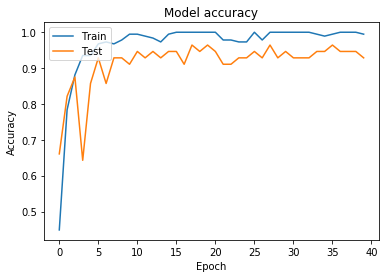

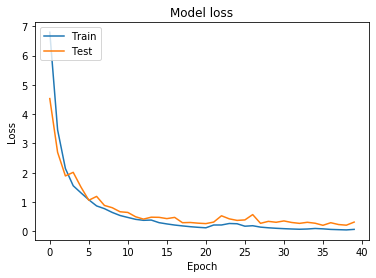

In [33]:
import matplotlib.pyplot as plt

plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Test del Modelo

In [16]:
from keras.models import load_model

#Si quiero guardo y/o cargo modelo desde disco con las funciones de abajo
#sino hago predicciones con el modelo recien entrenado en RAM

#model.save('reconocimientoFacial.h5')

#def cargar_modelo():
#modelo_cargado = load_model('faceRecognition_model.h5')#NOMBRE_MODELO
#    return model

# Predicciones estaticas
Del disco al programa, en formato .jpg

In [17]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py

#convert the images from RGB to BGR, then will zero-center each color channel with
#respect to the ImageNet dataset, without scaling.

In [ ]:
im_yo = '/Users/andresmanzalini/Documents/Andres_Prueba.jpg'
im_v = '/Users/andresmanzalini/Documents/V.jpg'
im_b = '/Users/andresmanzalini/Documents/Bn.jpg'
im_d = '/Users/andresmanzalini/Documents/D.jpg'

img = image.load_img(im_d, target_size=(224, 224))   #MAL!! el modelo o la prediccion?
print(img)
x = image.img_to_array(img)
print(x.dtype)
x = np.expand_dims(x, axis=0)
#print('x expandida ',x)
x = preprocess_input(x)     #RARO. esto parece que esta mal! que hace con la imagen?
#print('x preprocess ', x)  #wat?
prediccion = model.predict(x)
print(prediccion)
pred = np.argmax(prediccion) 
pred
tags[pred]

In [20]:
preds = prediccion[0][:]
print('predicciones ',preds)
print('etiqueta ',tags[pred])
print("prediccion: {0:.3f}". format(preds[pred]))


predicciones  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 4.0123867e-13 1.0000000e+00]
etiqueta  V
prediccion: 1.000


# Predicciones por webcam

Usa opencv y dlib.

Tener en cuenta que las imagenes del dataset tienen el formato RGB, predefinido por dlib al alinear las caras con chip_align(face), de la libreria PIL.

Por eso hay que ser consistentes con el formato de salida de la camara web, para entrenar y predecir con los mismos formatos y tipos de datos.



In [21]:
from keras import backend as K

#flashero metodo de preprocesamiento de Keras. Por que normaliza asi?

'''
def preprocess_input_keras(x, data_format=None, version=1):
    x_temp = np.copy(x)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863

    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError

    return x_temp
'''

"\ndef preprocess_input_keras(x, data_format=None, version=1):\n    x_temp = np.copy(x)\n    if data_format is None:\n        data_format = K.image_data_format()\n    assert data_format in {'channels_last', 'channels_first'}\n\n    if version == 1:\n        if data_format == 'channels_first':\n            x_temp = x_temp[:, ::-1, ...]\n            x_temp[:, 0, :, :] -= 93.5940\n            x_temp[:, 1, :, :] -= 104.7624\n            x_temp[:, 2, :, :] -= 129.1863\n        else:\n            x_temp = x_temp[..., ::-1]\n            x_temp[..., 0] -= 93.5940\n            x_temp[..., 1] -= 104.7624\n            x_temp[..., 2] -= 129.1863\n\n    elif version == 2:\n        if data_format == 'channels_first':\n            x_temp = x_temp[:, ::-1, ...]\n            x_temp[:, 0, :, :] -= 91.4953\n            x_temp[:, 1, :, :] -= 103.8827\n            x_temp[:, 2, :, :] -= 131.0912\n        else:\n            x_temp = x_temp[..., ::-1]\n            x_temp[..., 0] -= 91.4953\n            x_temp

In [22]:
#OpenCV
data_path_cv2 = cv2.__path__[0]+'/data/'
haar_type = 'haarcascade_frontalface_default.xml'

video = cv2.VideoCapture(0)
face_cascada = cv2.CascadeClassifier(data_path_cv2+haar_type)


#DLIB
path_DLIBmodel = os.path.dirname(os.getcwd())+'/shape_predictor_68_face_landmarks.dat'
land_detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_DLIBmodel)


seguir = True
while seguir:
    ret, frame = video.read()
    #gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frameRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #sobreescribo formato de salida de GBR a RGB 
    gris = cv2.cvtColor(frameRGB, cv2.COLOR_RGB2GRAY)
    
    key = cv2.waitKey(1) 

    caras_dlib = land_detector(gris,1)

    for cara in caras_dlib:
        x = cara.left()
        y = cara.top()
        w = cara.right() - x
        h = cara.bottom() - y
        
        landmarks = predictor(gris, cara)
        face_aligned = dlib.get_face_chip(frame, landmarks, 224)
        
        face_aligned_32 = np.asarray(face_aligned, dtype='float32') 
        #print('face aligned 32 ', face_aligned_32)
        im_expand = np.expand_dims(face_aligned_32, axis=0) 
        #print('expand ', im_expand.shape)
        im_normalizada = (im_expand - np.min(im_expand)) / (np.max(im_expand) - np.min(im_expand))
        #normalizando predice probabilidades!
        
        prediccion = model.predict(im_normalizada)
        
        pred = np.argmax(prediccion)
        proba = prediccion[:,pred]
        tag = tags[pred]

        #print('PREDICCION ', prediccion)
        #print('pred ',pred)
        #print('prob ',proba)
        #arreglar que no identifique a 2 personas con el mismo id!
        
        if proba > .5: # & reconoce al mismo id durante 2s
            print('{}: {}'.format(tag, proba))
            cv2.putText(frame, tag, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        
        cv2.rectangle(frame, (x,y), (cara.right(),cara.bottom()), (0,255,0), 3)
        
        for n in range(0,68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(frame, (x,y), 3, (255,0,0))

        cv2.imshow('Cara alineada', face_aligned)


    cv2.imshow('Frame',frame)
    
    if key == ord ('q'):
        seguir=False
        

video.release()
cv2.destroyAllWindows()


Andres: [0.60042363]
D: [0.8542848]
Andres: [0.98973316]
Andres: [0.939084]
Andres: [0.9936278]
V: [0.9427046]
D: [0.9400269]
Bene: [0.7223402]
Martin: [0.7451778]
V: [0.67325854]
Bene: [0.537768]
Andres: [0.99560696]
Andres: [0.99575883]
Bene: [0.5785836]
Ma: [0.8491212]
Bene: [0.58626187]
V: [0.65386915]
V: [0.89591616]
Martin: [0.87455845]
Bene: [0.9732896]
V: [0.77940804]
Bene: [0.72129345]
V: [0.99861026]
V: [0.9986958]
Bene: [0.8436593]
Bene: [0.96044225]
Bene: [0.9726428]
V: [0.9998073]
V: [0.99998367]
Martin: [0.5111512]
Bene: [0.729632]
Bene: [0.61810094]
Bene: [0.9176851]
Bene: [0.97441995]
Bene: [0.947715]
Bene: [0.9240215]
Bene: [0.99361163]
Bene: [0.98623115]
Bene: [0.5911229]
Martin: [0.7801086]
Bruga: [0.5037425]
Bene: [0.7230731]
D: [0.914251]
Andres: [0.9537152]
Andres: [0.997106]
Andres: [0.9722946]
Andres: [0.7538743]
Bene: [0.5984712]
V: [0.50401884]
V: [0.8029283]
Bene: [0.6041724]
Bene: [0.87348586]
Ma: [0.5421044]
Bene: [0.92360276]
Andres: [0.9999702]
Andres: [0

# InceptionV3

Resultados con poca precision comparados con VGG16

In [33]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [34]:
#redimensiono con default_size de InceptionV3, 299x299

generador = ImageDataGenerator(validation_split=0.2,
                               rescale=1./255,
                               shear_range = 0.2,
                               zoom_range=0.2,
                               horizontal_flip=True)


training_generator = generador.flow_from_directory('/Users/andresmanzalini/Documents/Datasets',
                                                   target_size = (299,299),
                                                   batch_size=8,
                                                   class_mode='categorical',
                                                   subset='training')

validation_generator = generador.flow_from_directory('/Users/andresmanzalini/Documents/Datasets',
                                                     target_size = (299,299),
                                                     batch_size=8,
                                                     class_mode='categorical',
                                                     subset='validation')

Found 188 images belonging to 8 classes.
Found 42 images belonging to 8 classes.


In [37]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)

x = Dense(256, activation='relu')(x)

predictions = Dense(cant_ids, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_191[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_192

In [38]:
for layer in base_model.layers:
    layer.trainable = False
    

model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


h = model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=50,
                        steps_per_epoch=len(training_generator),
                        validation_steps=len(validation_generator))


model.evaluate_generator(generator=validation_generator,
                         steps=len(validation_generator))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_191 (Conv2D)             (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, None, None, 3 96          conv2d_191[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, None, None, 3 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_192

Epoch 1/10
24/24 [==============================] - 54s 2s/step - loss: 4.1093 - acc: 0.1979 - val_loss: 2.0328 - val_acc: 0.2857
Epoch 2/10
24/24 [==============================] - 47s 2s/step - loss: 1.7744 - acc: 0.3438 - val_loss: 2.3772 - val_acc: 0.2857
Epoch 3/10
24/24 [==============================] - 49s 2s/step - loss: 1.4705 - acc: 0.4737 - val_loss: 3.7888 - val_acc: 0.2857
Epoch 4/10
24/24 [==============================] - 47s 2s/step - loss: 1.2135 - acc: 0.6351 - val_loss: 2.4413 - val_acc: 0.2381
Epoch 5/10
24/24 [==============================] - 46s 2s/step - loss: 1.1573 - acc: 0.6147 - val_loss: 2.6610 - val_acc: 0.1190
Epoch 6/10
24/24 [==============================] - 49s 2s/step - loss: 0.9243 - acc: 0.7033 - val_loss: 2.8689 - val_acc: 0.3810
Epoch 7/10
24/24 [==============================] - 46s 2s/step - loss: 0.7973 - acc: 0.7291 - val_loss: 2.0043 - val_acc: 0.4286
Epoch 8/10
24/24 [==============================] - 46s 2s/step - loss: 0.8850 - acc: 0.69

[2.7941472282012305, 0.47619047619047616]

In [40]:
#numero de capas para cortar al hacer fine tuning
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)


for layer in model.layers[:249]:
    layer.trainable = False #congelo primeras 249 capas
for layer in model.layers[249:]:
    layer.trainable = True    #descongelo el resto

# recompilar con SGD
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


h = model.fit_generator(generator=training_generator,
                        validation_data=validation_generator,
                        epochs=50,
                        steps_per_epoch=len(training_generator),
                        validation_steps=len(validation_generator))

model.evaluate_generator(generator=validation_generator,
                         steps=len(validation_generator))



0 input_4
1 conv2d_191
2 batch_normalization_189
3 activation_189
4 conv2d_192
5 batch_normalization_190
6 activation_190
7 conv2d_193
8 batch_normalization_191
9 activation_191
10 max_pooling2d_11
11 conv2d_194
12 batch_normalization_192
13 activation_192
14 conv2d_195
15 batch_normalization_193
16 activation_193
17 max_pooling2d_12
18 conv2d_199
19 batch_normalization_197
20 activation_197
21 conv2d_197
22 conv2d_200
23 batch_normalization_195
24 batch_normalization_198
25 activation_195
26 activation_198
27 average_pooling2d_19
28 conv2d_196
29 conv2d_198
30 conv2d_201
31 conv2d_202
32 batch_normalization_194
33 batch_normalization_196
34 batch_normalization_199
35 batch_normalization_200
36 activation_194
37 activation_196
38 activation_199
39 activation_200
40 mixed0
41 conv2d_206
42 batch_normalization_204
43 activation_204
44 conv2d_204
45 conv2d_207
46 batch_normalization_202
47 batch_normalization_205
48 activation_202
49 activation_205
50 average_pooling2d_20
51 conv2d_203
52

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#RESULTADOS

#mas complejo computacionalmente
#entrenando todas las capas:
    #de entrada mucho valor de perdida, se va acomodando
    #1.3 de perdida, 0.43 de precision

#con fine-tuning, congelando la estructura de la arquitectura y entrenando solo las ultimas capas
#UPAAAAA. esto no es coca papi. 
#es pepsi -_-, 
#con 5 epochs  =>   no sirve para reconocer caras. loss=1.03, acc=0.51
#con 10 epochs =>   una bazo... loss=1.5, acc=0.48 
                    #amaga con que arranca y es lo mejor, pero la queda siempre, en todos los epochs. 
                    #es el vivi hecho modelo de IA
#con 20 epochs =>   lo mismo

#no distingue bien los rostros, por lo que no puede clasificar con precision

# creo yo que es porque al tener tantas pequenas capas, apunta mas a los detalles 
# que a un conjunto de puntos mas complejos, como los que representan una cara


# Conclusion


El modelo base VGG16 es el mejor para la implementacion del proyecto, ya que extrae carecteristicas mas generales de las imagenes. En cambio el modelo InceptionV3 tiene muchas mas pequeñas capas y enfoca los detalles por sobre el objeto general.

Las métricas iniciales del VGG16 parecen consistentes, pero es sensible al underfitting.

Para eso una alternativa es aplicar fine tuning agregando al final 2 capas convolucionales para achicar el tensor y 2 fully conected para clasificar los rostros en el arreglo plano. 

A pesar de estas mejoras no clasifica del todo bien porque, en esta implementacion, las imagenes de prueba del dataset son pocas (considerando la carga manual con detectarProcesar_cara.py) 

Lo mas llamativo es la normalizacion establecida por keras_vggFace. No se que hace con la imagen de la webcam ni en que la transforma. Mejora la precision? Mmm

Para hacer efectivo un dataset chico hay que sacar el maximo provecho de la informacion: redes neuronales siamesas o facenet.

# En proceso...

# Redes siamesas 


One-shot learning

Comparo imagenes del mismo subconjunto y calculo el triplet loss

In [39]:
#from tensorflow.keras import Lambda
import tensorflow.keras.backend as K
from keras.layers import Input


In [69]:
#uso de triplet loss.
#compara de a 3 medidas a la vez, y se va aproximando al positivo a medida que entrena el algoritmo

vgg = VGG16(input_shape=(default_size), weights='imagenet', include_top=False)#, classes=3)

#vgg.summary()
for layer in vgg.layers:
    layer.trainable = False


vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [70]:
f = Flatten()(vgg.output) #aplano vgg con sus respectivos pesos definidos en imagenet

x = BatchNormalization()(f)

d = Dropout(0.2)(x)

#kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01))
out = Dense(4, activation='softmax')(d)


In [71]:
model = Model(input=vgg.input, outputs=out) #input model o vgg?

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/Users/andresmanzalini/miniconda3/envs/envDeepLearning/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [106]:
#seq_model = tf.keras.Sequential(vgg)

left_input = Input(shape=default_size)
right_input = Input(shape=default_size)

#model = Sequential()
#left_output = model(left_input)
right_output = vgg(right_input)
left_output

<tf.Tensor 'vgg16_4/block5_pool/MaxPool:0' shape=(?, 7, 7, 512) dtype=float32>

In [90]:
distance_euclid = Lambda(lambda tensors : K.abs( tensors[0] - tensors[1] ))([left_output , right_output])

In [93]:
outs = Dense(1 , activation='sigmoid')(distance_euclid)

#model = Model(input=vgg.input, outputs=out) #input model o vgg?

model = Model([left_input,right_input], outputs)
model = Model(inputs=[left_input, right_input], outputs=outs)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [94]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 7, 7, 512)    14714688    input_32[0][0]                   
                                                                 input_33[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 7, 7, 512)    0           vgg16[1][0]                      
          

In [74]:
# articulos sobre redes neuronales siamesas

# https://medium.com/predict/face-recognition-from-scratch-using-siamese-networks-and-tensorflow-df03e32f8cd0

# https://www.codeproject.com/Articles/1253224/Keras-Implementation-of-Siamese-like-Networks

# https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

# FaceNet

In [ ]:
# https://arxiv.org/pdf/1503.03832.pdf

# https://spanish.agatetepe.com.br/hacer-su-propio-sistema-de-reconocimiento-de-rostros/

In [ ]:
#el uso de vgg16 requiere la mencion del sgte paper 
# https://arxiv.org/abs/1409.1556

# Riesgos psicologicos de la programacion persuasiva con Redes Neuronales orientadas a deteccion de emociones 

Esto es para los que le gusta flasharla...

La combinacion de varios factores, como las mejoras tecnologicas en software y hardware, mas los avances en IA y la capacidad de manipulacion, permiten en el peor escenario, imaginar modelos de Deep Learning trabajando en conjunto y junto a la correcta sincronizacion de agentes inteligentes puede llevar a un desbalance psicologico/social.


Supongamos el super modelo llamado Modelo Persuasivo de Emociones(MPE), cuyo algoritmo principal consiste en detectar emociones y manejarlas con eventos desencadenantes.
Y los agentes inteligentes Agente Detector de Emociones y Agente de Feedback 

MPE en fase de aprendizaje, cada vez que se activa el Agente Detector de Emociones se revisan los eventos del sistema que desencadenaron esa reaccion. Puede ser un msj, un video, una cancion, un recordatorio, etc.

Cuando hay informacion suficiente sobre el sujeto(el usuario), el algoritmo persuasivo detecta que, por ejemplo, estás triste. Ese evento lo relaciona con las cosas que te hacen feliz (BD relacionada a 'eventos desencadenantes de emocion', lo que contrarresta la tristeza, es decir la felicidad).

A su vez, existe otro agente, el de Feedback, que analiza la reaccion global a cierto evento desencadenado por el agente persuasivo. Esto sirve para generar un feedback entre las emociones del usuario y las recomedaciones del sistema, mejorando el nivel de precision de los eventos sugeridos.

Cuando este modelo obtenga resultados predecibles, va a haber encontrado el patron de comportamiento de la persona.
Por lo tanto va a tener control la maquina por sobre el usuario.

La maquina? o los que manejan esa maquina?
